# Whitening in time-domain using AR model 



### Whitening in time domain
The parametric estimator for whitening in the time domain involves selecting a noise model, estimating its parameters from the data, and subtracting or filtering out the estimated noise component. In the time domain, a parametric estimator assumes a specific mathematical model or functional form for the noise. This model is typically characterized by a set of parameters that are estimated from the data. By fitting the model to the data, the parameters are determined, and the noise can be whitened by removing the estimated noise component. To apply a parametric estimator for whitening in the time domain, the first step is to select an appropriate model for the noise. Common choices include autoregressive (AR) models, autoregressive moving average (ARMA) models. These models capture different properties of the noise, such as its autocorrelation and spectral characteristics. Once the model is selected, the parameters of the model are estimated from the data. This estimation is typically done using methods such as maximum likelihood estimation (MLE) or least squares fitting. The estimated parameters describe the noise component that needs to be removed or filtered from the data. After estimating the parameters, the parametric estimator is applied to the data. The estimated noise component is subtracted or filtered out from the original data, leaving behind a whitened version of the data. This whitened data has reduced noise correlations and a more constant power spectral density, which enhances the detectability of gravitational wave signals. It's important to note that the effectiveness of the parametric estimator depends on the accuracy of the chosen noise model and the quality of the parameter estimation. If the model is a good fit for the noise characteristics and the parameter estimation is reliable, the whitening procedure can significantly improve the sensitivity of gravitational wave analysis. However, it's worth mentioning that the choice of parametric models and their applicability to gravitational wave search can be challenging. The noise in gravitational wave detectors often exhibits complex and non-stationary behavior, which may require more sophisticated modeling approaches or combinations of different models. While less commonly used compared to the frequency domain non-parametric methods, the parametric approach can be valuable in specific scenarios where the noise characteristics are well-modeled by the chosen parametric model. It provides an alternative approach to whitening in gravitational wave search, aiming to enhance the detectability of gravitational wave signals by reducing noise correlations and improving the data quality.
If you are interested also in time domain solution, you can have a look at these packages:

* https://github.com/elenacuoco/p4TSA

* https://wdfpipe.gitlab.io/ 

### Create AR model

In [1]:
import time
import os
import json 
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import Parameters
from wdf.processes.Whitening import Whitening
from wdf.processes.DWhitening import  DWhitening
from wdf.processes.DownSampling import *
from pytsa.tsa import FrameIChannel
import logging, sys

# Configure logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Set up logging output
console_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(console_handler)

# Log a debug message
logging.debug("info")
 
path = os.getcwd()
 
# parent directory

parent_dir=os.path.abspath(os.path.join(path, os.pardir))
#filein=os.path.join(parent_dir,"caches/E1.ffl")
MDC_PATH = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data"
filein=MDC_PATH+'/E1/E-E1_STRAIN_DATA-1000000000-2048.gwf'
# Flag to determine whether to create a new JSON configuration file
new_json_config_file = True

# Create or update JSON configuration file if needed
if new_json_config_file:
    configuration = {
      "file": filein,
      "channel": 'E1:STRAIN', 
      "len": 8.0,
      "gps": 1000000001.,
      "outdir": "./",
      "dir": "./", 
      "ARorder": 1000,
      "learn": 200,
      "preWhite": 4,
      "ResamplingFactor":4,
    }

filejson = os.path.join(os.getcwd(),"WavRecDS.json")
file_json = open(filejson, "w+")
json.dump(configuration, file_json)
file_json.close()


 
par = Parameters()
filejson = "WavRecDS.json"
try:
    par.load(filejson)
    logging.info("read parameters from JSON file")
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
par.resampling=par.sampling/par.ResamplingFactor
 
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.resampling))
whiten=Whitening(par.ARorder)

par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel)
par.LVfile ="./LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel)

if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
        logging.info('Load AR parameters')
        whiten.ParametersLoad(par.ARfile, par.LVfile)
else:
        logging.info('Start AR parameter estimation')
        ######## read data for AR estimation###############
        strLearn = FrameIChannel(
                    par.file, par.channel, par.learn, par.gps
                )
        Learn = SV()
        Learn_DS = SV()
        par.Noutdata = int(par.learn *par.resampling)
        ds = DownSampling(par,estimation=True)
        strLearn.GetData(Learn)
        Learn_DS=ds.Process(Learn)
        whiten.ParametersEstimate(Learn_DS)
        whiten.ParametersSave(par.ARfile, par.LVfile)
        del Learn, ds, strLearn, Learn_DS

read parameters from JSON file
channel= E1:STRAIN at sampling frequency= 2048.0
Load AR parameters


In [2]:
# sigma for the noise
par.sigma = whiten.GetSigma()
logging.info('Estimated sigma= %s' % par.sigma)

Estimated sigma= 1.24174e-23


In [3]:
N=int(par.resampling*par.len)
padlen=int(par.sampling/4)
par.Noutdata=N
ds = DownSampling(par,padlen=padlen)
Dwhiten=DWhitening(whiten.LV,N,0)
streaming = FrameIChannel(par.file, par.channel, par.len, par.gps)
data = SV()
dataw = SV()
dataww = SV()

if os.path.isfile(par.LVfile):
    logging.info('Load LV parameters')
    Dwhiten.ParametersLoad(par.LVfile)

 

###---whitening preheating---###
for i in range(par.preWhite):
    streaming.GetData(data)
    data_ds=ds.Process(data)
    whiten.Process(data_ds, dataw)
    Dwhiten.Process(data_ds, dataww) 
 
    

Estimation status is set to False. If you need to estimate AR, please update the value
Load LV parameters


In [4]:
streaming.GetData(data)
data_ds=ds.Process(data)
whiten.Process(data_ds, dataw)
Dwhiten.Process(data_ds, dataww)

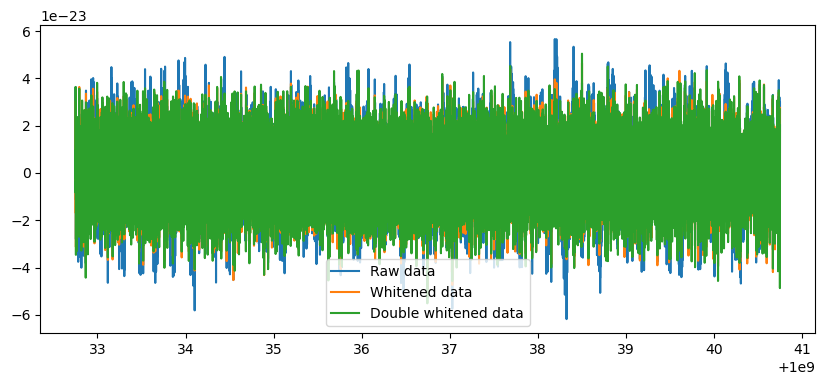

In [5]:
 # Import necessary libraries and modules
import matplotlib.pyplot as plt
import IPython
import IPython.display
import matplotlib as mpl
from matplotlib import cm
from scipy import signal
from matplotlib.colors import LogNorm
from PIL import Image
# Import NumPy library
import numpy as np
# Set matplotlib configuration parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 

x=np.zeros(dataw.GetSize())
y=np.zeros(dataw.GetSize())
yw=np.zeros(dataw.GetSize())
yww=np.zeros(dataww.GetSize())
for i in range(dataw.GetSize()):
    x[i]=data_ds.GetX(i)
    y[i]=data_ds.GetY(0,i)
    yw[i]=dataw.GetY(0,i)
    yww[i]=dataww.GetY(0,i)



# Plotting
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='Raw data')
plt.plot(x, yw, label='Whitened data')
plt.plot(x, yww, label='Double whitened data')

# Add legend
plt.legend()

# Show plot
plt.show()
plt.close()


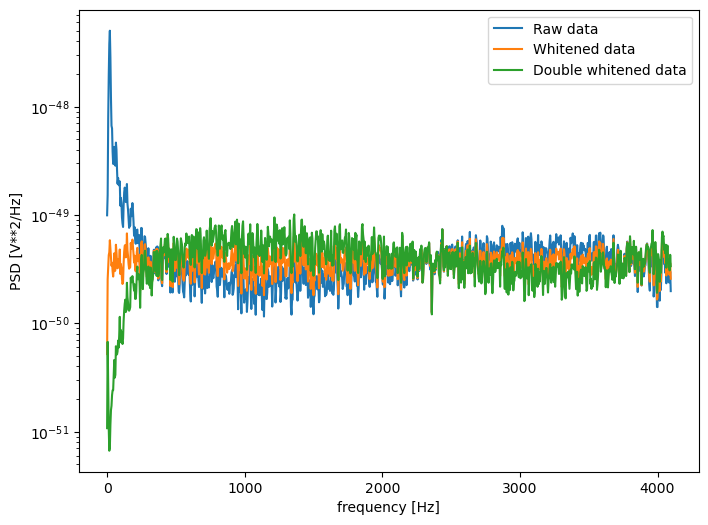

In [6]:
 

# Calculate power spectral density (PSD) using Welch's method
f, Pxx_den = signal.welch(y, par.sampling, nperseg=2048)
f, Pxx_denW = signal.welch(yw, par.sampling, nperseg=2048)
f, Pxx_denWW = signal.welch(yww, par.sampling, nperseg=2048)

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot PSD for raw data
ax.semilogy(f, Pxx_den, label='Raw data')

# Plot PSD for whitened data
ax.semilogy(f, Pxx_denW, label='Whitened data')

# Plot PSD for double whitened data
ax.semilogy(f, Pxx_denWW, label='Double whitened data')

# Set labels for x and y axes
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

# Add legend
plt.legend()

# Show plot
plt.show()
plt.close()


## <span style="color:purple">Challenge: what change if you use a different number of AR model? Explain why.</span> 